<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [ ]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [ ]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z * torch.exp(-self.s)
        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [ ]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

100%|██████████| 9912422/9912422 [00:00<00:00, 95638567.72it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36041563.17it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31273390.51it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5297699.88it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



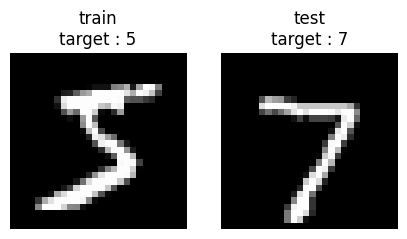

In [ ]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [ ]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=128, num_flows=15)

train_loader = DataLoader(train_data, batch_size=5000, shuffle=True)


In [ ]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1083.54443359375
Epoch :  2   -----------> Loss :  989.8614959716797
Epoch :  3   -----------> Loss :  898.6088562011719
Epoch :  4   -----------> Loss :  807.9853769938151
Epoch :  5   -----------> Loss :  718.2972920735677
Epoch :  6   -----------> Loss :  628.8096872965494
Epoch :  7   -----------> Loss :  541.910774230957
Epoch :  8   -----------> Loss :  456.4193344116211
Epoch :  9   -----------> Loss :  375.0050404866536
Epoch :  10   -----------> Loss :  297.3667678833008
Epoch :  11   -----------> Loss :  221.05715942382812
Epoch :  12   -----------> Loss :  147.78929646809897
Epoch :  13   -----------> Loss :  80.63241608937581
Epoch :  14   -----------> Loss :  20.528024872144062
Epoch :  15   -----------> Loss :  -45.76571639378866
Epoch :  16   -----------> Loss :  -109.0836690266927
Epoch :  17   -----------> Loss :  -164.67913691202799
Epoch :  18   -----------> Loss :  -208.36846160888672
Epoch :  19   -----------> Loss :  -260.99055353

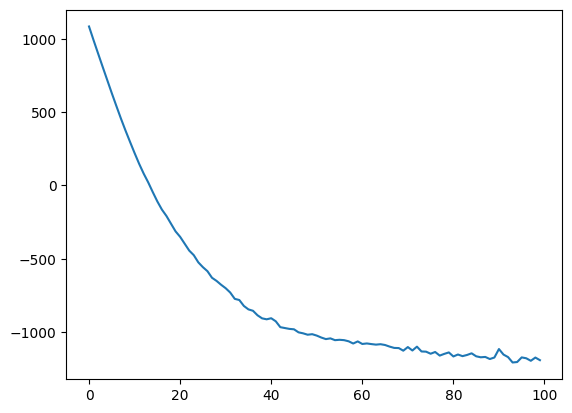

In [ ]:
plt.plot(COST)

In [ ]:
test = prior.sample((50,))
test

tensor([[-1.9099,  0.9799, -0.0787,  ..., -0.9386,  1.7676,  0.7446],
        [-1.0348,  0.6906,  2.0911,  ..., -0.7706, -1.3685, -0.9800],
        [ 0.1197,  1.7896, -0.5496,  ...,  2.5932, -0.8963,  0.3427],
        ...,
        [ 0.6176, -1.5679, -0.1745,  ..., -0.6630, -0.2662,  0.0598],
        [ 1.3293,  0.7464,  0.3629,  ...,  0.6018,  2.0176,  0.1134],
        [ 0.9521, -0.0421,  0.2884,  ...,  0.3247,  0.3235, -1.3682]])

In [ ]:
sonuc = model.f_inv(test)
sonuc

tensor([[-0.0110,  0.0053,  0.0003,  ..., -0.0046,  0.0081, -0.0009],
        [-0.0058,  0.0036,  0.0112,  ..., -0.0038, -0.0066, -0.0105],
        [ 0.0013,  0.0099, -0.0020,  ...,  0.0123, -0.0042, -0.0028],
        ...,
        [ 0.0042, -0.0092, -0.0005,  ..., -0.0033, -0.0010, -0.0052],
        [ 0.0083,  0.0038,  0.0026,  ...,  0.0028,  0.0091, -0.0061],
        [ 0.0062, -0.0007,  0.0020,  ...,  0.0012,  0.0014, -0.0142]],
       grad_fn=<CopySlices>)

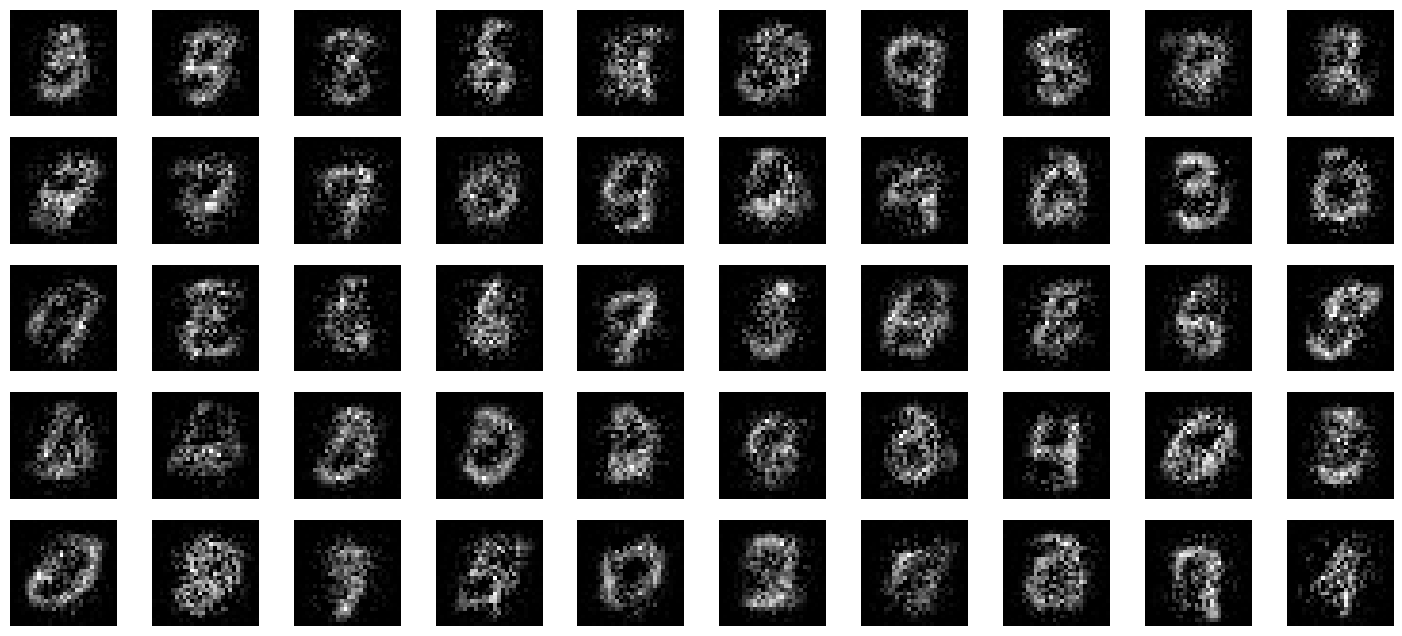

In [ ]:
test = prior.sample((50,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8))

for i in range(0,10):

    axs[0, i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((28,28)), cmap='gray')
    axs[1, i].imshow(torch.nn.ReLU()(sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='gray')
    axs[2, i].imshow(torch.nn.ReLU()(sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='gray')
    axs[3, i].imshow(torch.nn.ReLU()(sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='gray')
    axs[4, i].imshow(torch.nn.ReLU()(sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
    axs[3, i].axis('off')
    axs[4, i].axis('off')
fig.show()